<h1> 1. Modelos de medias móviles MA(q) </h1>

Los modelos de medias móviles predicen el valor actual de nuestra serie temporal en función de los residuos pasados. Un modelo de medias móviles de orden simple $MA(1)$, de orden uno, sólo consideraría el valor del resiudo en el período anterior ($\varepsilon _{t-1}$), y el modelo se expresaría de la siguiente manera: $$x_t=c+\theta _1 \varepsilon _{t-1}+\varepsilon _t$$
Además, $|\theta _1|<1$, es decir, $-1<\theta _1<1$


De manera general, tendremos:
$$x_t=c+\theta _1 \varepsilon _{t-1}+\theta _2 \varepsilon _{t-2}+\cdots + \theta _q \varepsilon _{t-q}+\varepsilon _t$$
Donde:
* $x_t:$ es el valor de interés, del período actual, de nuestra serie de tiempo.
* $c:$ es la constante.
* $\theta _1, \ldots, \theta _q:$ Son los coeficientes que debemos estimar.
* $\varepsilon _t$ es el residuo en el período actual.

Para que funcione bien este modelo, **LOS DATOS DEBEN SER ESTACIONARIOS**.

En este caso, observaremos la $ACF$

Nota: $\hat{x_t}=x_t+\varepsilon _t$

<h1> Packages </h1>

In [1]:
import numpy as np # Para utilizar numpy
import pandas as pd # Para utilizar pandas
import matplotlib.pyplot as plt #Para las gráficas
import statsmodels.graphics.tsaplots as sgt #Gráficas de autocorrelación 
import statsmodels.tsa.stattools as sts #Para prueba de Dickey-Fuller
import seaborn as sns 
from statsmodels.tsa.arima.model import ARIMA #Para hacer el modelo ARIMA
from scipy.stats.distributions import chi2 #Nos sirve para la distribución Xi cuadrada 
from datetime import datetime #Para trabajar con fechas
import os #Para poner la dirección donde esta la base de datos.
sns.set()

<h1> Preprocesamiento de datos </h1>

In [2]:
os.chdir("C:\\Users\\81799\\OneDrive\\Documentos\\ESFM_CLASES\\Servicio Social ARTF\\Machine Learning\\curso-series-temporales-master\\5. Modelos AR autorregresivos\\Python") 
raw_csv_data = pd.read_csv("Index2018.csv") #Leer DataFrame Index2018
df_comp = raw_csv_data.copy() #Copia el DataFrame raw_csv_data con el nombre de df_comp
df_comp.date = pd.to_datetime(df_comp.date, dayfirst =True ) #Modifica las fechas
df_comp.set_index("date",inplace = True) # Ponemos las fechas como índices
df_comp=df_comp.asfreq("b") #Frecuencias a días laborales.
df_comp=df_comp.fillna(method="ffill")#Arregla problema d valores faltantes tomando su diferencia
df_comp["market_value"]=df_comp.ftse #Agregamos una nueva columna llamada market_value
del df_comp["spx"] #Eliminamos la columna spx del DataFrame de_comp
del df_comp["dax"] #Eliminamos la columna dax del DataFrame de_comp
del df_comp["ftse"] #Eliminamos la columna ftse del DataFrame de_comp
del df_comp["nikkei"] #Eliminamos la columna nikkei del DataFrame de_comp
size=int(len(df_comp)*0.8) #int (no. de filas*0.8)= int(6277*0.8)= int(5021.6)=5021
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]
df #Datos de entrenamiento   ..... df_test = Datos de prueba

,market_value
date,
1994-01-07,3445.98
1994-01-10,3440.58
1994-01-11,3413.77
1994-01-12,3372.02
1994-01-13,3360.01
...,...
2013-04-01,6411.74
2013-04-02,6490.66
2013-04-03,6420.28


<h1> Prueba de Razón de Log-LikeLihood </h1>

In [3]:
def LLR_test(mod_1,mod_2,DF=1): #DF son los grados de libertad
    L1=mod_1.llf # Me da Log Likelihood del mod_1 que de como entrada
    L2=mod_2.llf # Me da Log Likelihood del mod_2 que de como entrada
    LR=(2*(L2-L1)) # Estadístico de prueba
    p=chi2.sf(LR,DF).round(3) #P-valor
    return p

In [4]:
import warnings  #Ignorar errores
warnings.filterwarnings("ignore")

<h1> Usando Retornos </h1>


En la sección de Modelos AR, lo hicimos para obtener una serie estacionaria.

In [5]:
df["retornos"]=df.market_value.pct_change(1)*100
df

,market_value,retornos
date,,
1994-01-07,3445.98,NaN
1994-01-10,3440.58,-0.156704
1994-01-11,3413.77,-0.779229
1994-01-12,3372.02,-1.222988
1994-01-13,3360.01,-0.356166
...,...,...
2013-04-01,6411.74,0.000000
2013-04-02,6490.66,1.230867
2013-04-03,6420.28,-1.084327


<h1> ACF para Returns </h1>

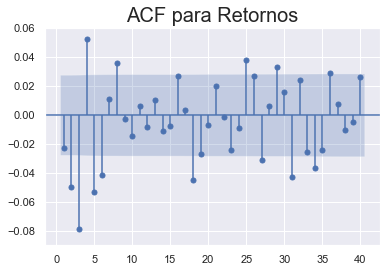

In [6]:
sgt.plot_acf(df.retornos[1:], zero = False, lags = 40) 
plt.title("ACF para Retornos", size = 20)
plt.ylim(-0.09,0.06)
plt.show() #Quitamos el primer NA para que nos de la gráfica

* Los valores $\varphi $ varían mucho.
* Notamos que los valores de autocorrelación para $\varphi _2, \varphi _3, \varphi _4, \varphi _5, \varphi _6, \varphi _8,\ldots $ son significativos, ya que están arriba de la franja azul. OJO: Más adelante al comparar los modelos, tiene que ver con está gráfica.

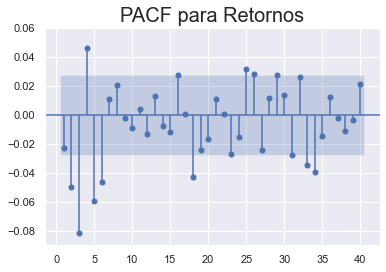

In [7]:
sgt.plot_pacf(df.retornos[1:], zero = False, lags = 40,alpha =0.05, method = "ols") 
plt.title("PACF para Retornos", size = 20)
plt.ylim(-0.09,0.06)
plt.show() #Quitamos el primer NA para que nos de la gráfica

Por la gráfica, nuestra intución dicta que cuanto más retrocedemos menos relevante serán los coeficientes.

<h1> MA(1) para retornos </h1>

In [8]:
model_ma_1 = ARIMA(df.retornos[1:], order = (0,0,1)) #MA(1)
results_ma_1 = model_ma_1.fit() 
results_ma_1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               retornos   No. Observations:                 5020
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -7929.595
Date:                Tue, 24 May 2022   AIC                          15865.190
Time:                        05:45:51   BIC                          15884.754
Sample:                    01-10-1994   HQIC                         15872.045
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.146      0.252      -0.013       0.051
ma.L1         -0.0257      0.009     -3.018      0.003      -0.042      -0.009
sigma2         1.3789      0.014     99.990      0.000       1.352       1.406
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              7852.85
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               2.04   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Dado lo anterior, tenemos que:

* El $p-valor$ del coeficiente $c$ es igual a $0.252$, lo cual indica que $p-valor _c >0.05$, por lo cual aceptamos $H_0$, así que **el coeficiente de c es significativamente igual a $0$**.

* El $p-valor$ del coeficiente $\theta _1$ es igual a $0.003$, lo cual indica que $p-valor _{\theta _1} <0.05$, por lo cual Rechazamos $H_0$, así que **el coeficiente de $\theta _1$ es significativamente diferente de $0$**.


<h1>Comparando Modelos AR (p) Higher-Lag sobre Returns </h1>

* Si al comparar los modelos $AR(p)$ con $AR(p+l)$ obtenemos que los modelos son diferentes, escogeremos el de mayor complejidad, siempre y cuando el último coeficiente de $AR(p+l)$ sea significativamente distinto de $0$


La siguiente función *LLR_test(mod_1,mod_2,DF)* Nos sirve para obtener el $p-valor$ de la comparación de dos modelos.

In [9]:
model_ma_2 = ARIMA(df.retornos[1:], order =(0,0,2))
results_ma_2 = model_ma_2.fit()
print(results_ma_2.summary())
print("LRR test: "+str(LLR_test(results_ma_1, results_ma_2)))

                               SARIMAX Results                                
Dep. Variable:               retornos   No. Observations:                 5020
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -7922.864
Date:                Tue, 24 May 2022   AIC                          15853.728
Time:                        05:45:55   BIC                          15879.812
Sample:                    01-10-1994   HQIC                         15862.868
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.204      0.228      -0.012       0.049
ma.L1         -0.0327      0.009     -3.760      0.000      -0.050      -0.016
ma.L2         -0.0502      0.008     -6.416      0.0

En este caso: $MA(1)$ y $MA(2)$

* El $p-valor$ del coeficiente $\theta _2$ es $0.000$, lo cual tendremos que $p-valor _{\theta _2}<0.05$, por lo cual **Rechazamos** $H_0$ y concluimos que $\theta _2$ es significativamente distinto de $0$.

* Al realizar la **Prueba de Razón Log-LikeLihood** respecto a $MA(1)$ y $MA(2)$ tenemos que $p-valor <\alpha $, es decir $0.0<0.05$, con esto **Rechazamos** $H_0$ y tenemos que los dos modelos son significativamente diferentes.


Dado los anteriores puntos, nos quedamos con el modelo $MA(2)$, ya que tiene mayor complejidad y $\theta _2$ es significativamente distinto de $0$


<h2> MA(2) y AR(3) </h2>

In [10]:
model_ma_3 = ARIMA(df.retornos[1:], order =(0,0,3))
results_ma_3 = model_ma_3.fit()
print(results_ma_3.summary())
print("LRR test: "+str(LLR_test(results_ma_2, results_ma_3)))

                               SARIMAX Results                                
Dep. Variable:               retornos   No. Observations:                 5020
Model:                 ARIMA(0, 0, 3)   Log Likelihood               -7904.317
Date:                Tue, 24 May 2022   AIC                          15818.634
Time:                        05:46:01   BIC                          15851.240
Sample:                    01-10-1994   HQIC                         15830.060
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.296      0.195      -0.010       0.048
ma.L1         -0.0203      0.009     -2.334      0.020      -0.037      -0.003
ma.L2         -0.0556      0.008     -7.032      0.0

En este caso: $MA(2)$ y $MA(3)$

* El $p-valor$ del coeficiente $\theta _3$ es $0.000$, lo cual tendremos que $p-valor _{\theta _3}<0.05$, por lo cual **Rechazamos** $H_0$ y concluimos que $\theta _3$ es significativamente distinto de $0$.

* Al realizar la **Prueba de Razón Log-LikeLihood** respecto a $MA(2)$ y $MA(3)$ tenemos que $p-valor <\alpha $, es decir $0.0<0.05$, con esto **Rechazamos** $H_0$ y tenemos que los dos modelos son significativamente diferentes.


Dado los anteriores puntos, nos quedamos con el modelo $MA(3)$, ya que tiene mayor complejidad y $\theta _3$ es significativamente distinto de $0$


<h2> MA(3) y AR(4) </h2>

In [11]:
model_ma_4 = ARIMA(df.retornos[1:], order =(0,0,4))
results_ma_4 = model_ma_4.fit()
print(results_ma_4.summary())
print("LRR test: "+str(LLR_test(results_ma_3, results_ma_4)))

                               SARIMAX Results                                
Dep. Variable:               retornos   No. Observations:                 5020
Model:                 ARIMA(0, 0, 4)   Log Likelihood               -7898.773
Date:                Tue, 24 May 2022   AIC                          15809.547
Time:                        05:46:07   BIC                          15848.674
Sample:                    01-10-1994   HQIC                         15823.257
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.236      0.217      -0.011       0.049
ma.L1         -0.0203      0.009     -2.239      0.025      -0.038      -0.003
ma.L2         -0.0551      0.008     -6.835      0.0

En este caso: $MA(3)$ y $MA(4)$

* El $p-valor$ del coeficiente $\theta _4$ es $0.000$, lo cual tendremos que $p-valor _{\theta _4}<0.05$, por lo cual **Rechazamos** $H_0$ y concluimos que $\theta _4$ es significativamente distinto de $0$.

* Al realizar la **Prueba de Razón Log-LikeLihood** respecto a $MA(3)$ y $MA(4)$ tenemos que $p-valor <\alpha $, es decir $0.001<0.05$, con esto **Rechazamos** $H_0$ y tenemos que los dos modelos son significativamente diferentes.


Dado los anteriores puntos, nos quedamos con el modelo $MA(4)$, ya que tiene mayor complejidad y $\theta _4$ es significativamente distinto de $0$


<h2> MA(4) y AR(5) </h2>

In [12]:
model_ma_5 = ARIMA(df.retornos[1:], order =(0,0,5))
results_ma_5 = model_ma_5.fit()
print(results_ma_5.summary())
print("LRR test: "+str(LLR_test(results_ma_4, results_ma_5)))

                               SARIMAX Results                                
Dep. Variable:               retornos   No. Observations:                 5020
Model:                 ARIMA(0, 0, 5)   Log Likelihood               -7892.823
Date:                Tue, 24 May 2022   AIC                          15799.645
Time:                        05:46:15   BIC                          15845.294
Sample:                    01-10-1994   HQIC                         15815.641
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.282      0.200      -0.010       0.048
ma.L1         -0.0262      0.009     -2.839      0.005      -0.044      -0.008
ma.L2         -0.0497      0.008     -6.147      0.0

En este caso: $MA(4)$ y $MA(5)$

* El $p-valor$ del coeficiente $\theta _5$ es $0.000$, lo cual tendremos que $p-valor _{\theta _5}<0.05$, por lo cual **Rechazamos** $H_0$ y concluimos que $\theta _5$ es significativamente distinto de $0$.

* Al realizar la **Prueba de Razón Log-LikeLihood** respecto a $MA(4)$ y $MA(5)$ tenemos que $p-valor <\alpha $, es decir $0.001<0.05$, con esto **Rechazamos** $H_0$ y tenemos que los dos modelos son significativamente diferentes.


Dado los anteriores puntos, nos quedamos con el modelo $MA(5)$, ya que tiene mayor complejidad y $\theta _5$ es significativamente distinto de $0$


<h2> MA(5) y AR(6) </h2>

In [13]:
model_ma_6 = ARIMA(df.retornos[1:], order =(0,0,6))
results_ma_6 = model_ma_6.fit()
print(results_ma_6.summary())
print("LRR test: "+str(LLR_test(results_ma_5, results_ma_6)))

                               SARIMAX Results                                
Dep. Variable:               retornos   No. Observations:                 5020
Model:                 ARIMA(0, 0, 6)   Log Likelihood               -7889.221
Date:                Tue, 24 May 2022   AIC                          15794.442
Time:                        05:46:24   BIC                          15846.612
Sample:                    01-10-1994   HQIC                         15812.723
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.014      1.318      0.188      -0.009       0.047
ma.L1         -0.0237      0.009     -2.562      0.010      -0.042      -0.006
ma.L2         -0.0486      0.008     -5.982      0.0

En este caso: $MA(5)$ y $MA(6)$

* El $p-valor$ del coeficiente $\theta _6$ es $0.000$, lo cual tendremos que $p-valor _{\theta _6}<0.05$, por lo cual **Rechazamos** $H_0$ y concluimos que $\theta _6$ es significativamente distinto de $0$.

* Al realizar la **Prueba de Razón Log-LikeLihood** respecto de $MA(5)$ y $MA(6)$ tenemos que $p-valor <\alpha $, es decir $0.007<0.05$, con esto **Rechazamos** $H_0$ y tenemos que los dos modelos son significativamente diferentes.


Dado los anteriores puntos, nos quedamos con el modelo $MA(6)$, ya que tiene mayor complejidad y $\theta _6$ es significativamente distinto de $0$


<h2> MA(6) y AR(7) </h2>

In [14]:
model_ma_7= ARIMA(df.retornos[1:], order =(0,0,7))
results_ma_7 = model_ma_7.fit()
print(results_ma_7.summary())
print("LRR test: "+str(LLR_test(results_ma_6, results_ma_7)))

                               SARIMAX Results                                
Dep. Variable:               retornos   No. Observations:                 5020
Model:                 ARIMA(0, 0, 7)   Log Likelihood               -7889.046
Date:                Tue, 24 May 2022   AIC                          15796.091
Time:                        05:46:37   BIC                          15854.782
Sample:                    01-10-1994   HQIC                         15816.657
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.303      0.193      -0.010       0.047
ma.L1         -0.0247      0.009     -2.645      0.008      -0.043      -0.006
ma.L2         -0.0488      0.008     -6.000      0.0

En este caso: $MA(6)$ y $MA(7)$

* El $p-valor$ del coeficiente $\theta _7$ es $0.343$, lo cual tendremos que $p-valor _{\theta _7}>0.05$, por lo cual **Aceptamos** $H_0$ y concluimos que $\theta _7$ es significativamente igual a $0$.

* Al realizar la **Prueba de Razón Log-LikeLihood** respecto de $MA(6)$ y $MA(7)$ tenemos que $p-valor >\alpha $, es decir $0.554<0.05$, con esto **Aceptamos** $H_0$ y tenemos que los dos modelos son significativamente iguales.


Dado los anteriores puntos, nos quedamos con el modelo $MA(6)$, ya que como son iguales escogemos el más simple.


<h2> MA(6) y AR(8) </h2>

In [15]:
model_ma_8= ARIMA(df.retornos[1:], order =(0,0,8))
results_ma_8 = model_ma_8.fit()
print(results_ma_8.summary())
print("LRR test: "+str(LLR_test(results_ma_6, results_ma_8, DF=2)))

                               SARIMAX Results                                
Dep. Variable:               retornos   No. Observations:                 5020
Model:                 ARIMA(0, 0, 8)   Log Likelihood               -7885.603
Date:                Tue, 24 May 2022   AIC                          15791.205
Time:                        05:46:52   BIC                          15856.417
Sample:                    01-10-1994   HQIC                         15814.056
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.253      0.210      -0.011       0.048
ma.L1         -0.0238      0.009     -2.527      0.011      -0.042      -0.005
ma.L2         -0.0495      0.008     -6.053      0.0

En este caso: $MA(6)$ y $MA(8)$

* El $p-valor$ del coeficiente $\theta _8$ es $0.000$, lo cual tendremos que $p-valor _{\theta _8}<0.05$, por lo cual **Rechazamos** $H_0$ y concluimos que $\theta _7$ es significativamente distinto de $0$.

* Al realizar la **Prueba de Razón Log-LikeLihood** respecto de $MA(6)$ y $MA(8)$ tenemos que $p-valor <\alpha $, es decir $0.027<0.05$, con esto **Rechamos** $H_0$ y tenemos que los dos modelos son significativamente distintos.


Dado los anteriores puntos, nos quedamos con el modelo $MA(8)$,  ya que tiene mayor complejidad y $\theta _8$ es significativamente distinto de $0$
 

<h1> Residuales para Retornos </h1>

In [16]:
import math
df["retornos_ajustados_MA_8"]=results_ma_8.fittedvalues
df["residuos_retornos_MA_8"]=results_ma_8.resid
media = round(df.residuos_retornos_MA_8.mean())
varianza = round(df.residuos_retornos_MA_8.var(),3)
desviacion_estandar = round(pow(varianza,0.5),3)
print(f"Los residuos tiene media = {media}"+f",varianza = {varianza}"+
      f" y desviación estandar = { desviacion_estandar}" )

Los residuos tiene media = 0,varianza = 1.355 y desviación estandar = 1.164


Esperamos que la mayoría de nuestros residuos se encuentren en el intervalo $[-3\sigma , 3\sigma ]$, es decir $[-3(1.164),3(1.164)]=[-3.492,3.492]$

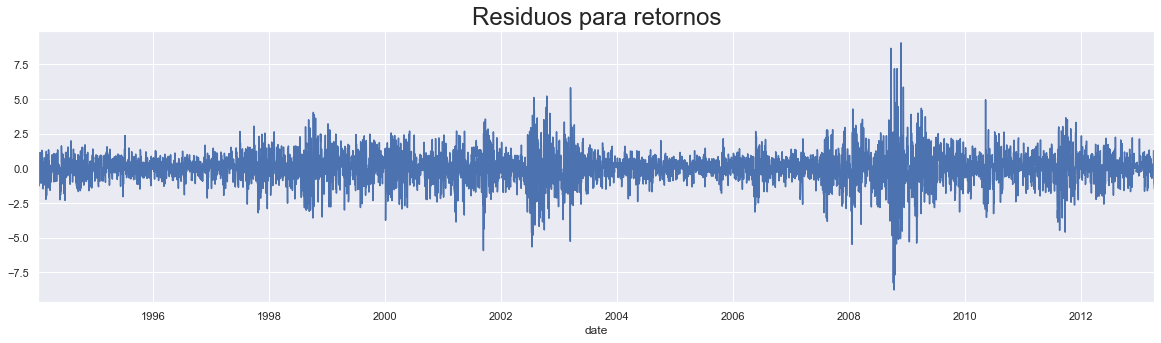

In [17]:
df.residuos_retornos_MA_8.plot(figsize = (20,5))
plt.title("Residuos para retornos", size = 24)
plt.show()

<h1> Dickey-Fuller a residuos </h1>

Para que los residuos se comporten como un ruido blanco, recordemos que deben de ser estacionarios.

In [18]:
sts.adfuller(df.residuos_retornos_MA_8[1:])

(-70.83777222126348,
 0.0,
 0,
 5019,
 {'1%': -3.4316535759402753,
  '5%': -2.8621160400844468,
  '10%': -2.567076626752987},
 15689.881935682564)

Con un $p-valor<0.05$, es decir $0.0<0.05$ **Rechazamos** $H_0$ y concluimos que los datos de la columna residuos_retornos son estacionarios.

<h1> Gráfica de ACF para residuos de retorno </h1>

Esto nos servirá para ver si hay autocorrelación significativa dado los residuos.

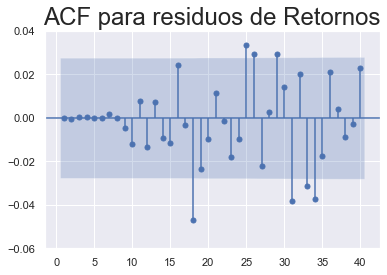

In [19]:
sgt.plot_acf(df.residuos_retornos_MA_8[1:], zero = False, lags = 40) 
plt.title("ACF para residuos de Retornos", size = 24)
plt.ylim(-0.06,0.04)
plt.show() #Quitamos el primer NA para que nos de la gráfica

Observamos que los primeros $17$ períodos, los valores de nuestra autocorrelación $\varphi _1, \ldots , \varphi _{17}$ NO son significativos, esto quiere decir que nuestro modelo es bueno.

<h1> Transformación de Normalización </h1>

Se prefiere usar los **Retornos** en lugar de los precios, al usar modelos autorregresivos $AR(p)$, esto se debe a la naturaleza de los precios.

Otra transformación sería a través de **normalización**, en este caso, cuando normalizamos un conjunto de valores básicamente mapeamos cada valor del espacio muestral y lo convertimos en un porcentaje con respecto al $1$er valor del conjunto, en lo cual nos dará como resultado una tasa. De esta manera la serie resultante, es mucho más fácil de comparar con otra serie de tiempo normalizada con respecto al $1$er valor.

En general, al normalizar dos series de tiempo cuyos valores representan precios, podemos compararlas entre sí, y esto nos da una mejor comprensión de cuales debemos invertir y cuales debemos evitar.

In [31]:
benchmark = df.market_value.iloc[0]#Escogemos el 1er valor de market.value
del df["retornos"] # Elimina columna retornos
del df["retornos_ajustados_MA_8"] # Elimina columna retornos_ajustados_MA_8
del df["residuos_retornos_MA_8"] # Elimina columna residuos_retornos_MA_8
df["Precios_Normalizados"]=df.market_value.div(benchmark).mul(100) #Tasa
print(f"{df}\n \nbenchmark = {benchmark}")


            market_value  Precios_Normalizados
date                                          
1994-01-07       3445.98            100.000000
1994-01-10       3440.58             99.843296
1994-01-11       3413.77             99.065288
1994-01-12       3372.02             97.853731
1994-01-13       3360.01             97.505209
...                  ...                   ...
2013-04-01       6411.74            186.064342
2013-04-02       6490.66            188.354546
2013-04-03       6420.28            186.312167
2013-04-04       6344.11            184.101765
2013-04-05       6249.77            181.364082

[5021 rows x 2 columns]
 
benchmark = 3445.98


<h1> Aplicando DF a los datos normalizados </h1>

In [32]:
sts.adfuller(df["Precios_Normalizados"])

(-1.9041551418836233,
 0.3301089327703129,
 6,
 5014,
 {'1%': -3.4316548765428174,
  '5%': -2.8621166146845334,
  '10%': -2.5670769326348926},
 19541.17381480549)

Como $p-valor>\alpha $, es decir, $0.3301>0.05$ entonces **Aceptamos** $H_0$ y concluimos que los precios normalizados con el $1$er valor son NO estacionarios, por lo tanto no podríamos usar los modelos $AR(p)$ ni $MA(q)$, ya que estos para que funcionen bien la serie debe de ser estacionaria.

Sin embargo, la  **Normalización** sigue siendo una gran práctica para **comparar series de tiempo**, y lo que se vio anteriormente es que *Normalizar los datos no afecta la NO estacionariedad de la serie.*